In [4]:
# Import necessary libraries and modules
import gc
import json
import os
import pickle
import warnings
import itertools
import time
import cudf

# Machine learning libraries

from cuml.ensemble import RandomForestRegressor as cuRF
from cuml.linear_model import Ridge, ElasticNet
import cupy as cp
from lightgbm import LGBMRegressor
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Suppress specific warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Metric Computation Functions
**Purpose**: Define a utility function to compute regression performance metrics (MSE, RMSE, MAE, R², etc.) that will be used later to compare the predictive accuracy of different models.

In [5]:
import numpy as np
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    median_absolute_error,
    explained_variance_score
)

# Compute Metrics Function
def compute_regression_metrics(y_true, y_pred):
    """
    Compute regression metrics and return as a dictionary.
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Median Absolute Error': medae,
        'Explained Variance': evs
    }
    
    return metrics

## Data Loading and Feature Engineering

**Purpose**: Define predictor and target columns, load data from parquet files, and create additional lag features to enrich the dataset.

In [6]:
#####################################
# 1. SETUP SECTION
#####################################

# Define predictor columns and target columns.
predictor_cols = [
    'bid', 'spread_minus', 'bbo_moving_trade', 'non_bbo_moving_trade', 'bbo_improving_limit',
    'bbo_worsening_cancel', 'bbo_depth_add_limit', 'bbo_depth_remove_cancel',
    'non_bbo_depth_add_limit', 'non_bbo_depth_remove_cancel', 'non_bbo_deep_depth_add_limit',
    'non_bbo_deep_depth_remove_cancel', 'bbo_depth_imbalance_minus', 
    'non_bbo_depth_imbalance_minus', 'non_bbo_deep_depth_imbalance_minus', 
    'bbo_queue_length_immbalance_minus', 'block_2', 'block_3', 'block_4', 'block_5', 'block_6'
]

# Additional observable features and their replicates.
ob_features = [
    'bbo_moving_trade', 'non_bbo_moving_trade', 'bbo_improving_limit',
    'bbo_worsening_cancel', 'bbo_depth_add_limit', 'bbo_depth_remove_cancel',
    'non_bbo_depth_add_limit', 'non_bbo_depth_remove_cancel', 
    'non_bbo_deep_depth_add_limit', 'non_bbo_deep_depth_remove_cancel'
]
for feat in ob_features:
    for r in range(1, 4):
        predictor_cols.append(f'{feat}_{r}')

# Define target columns
# target_cols = ['px_imp_0', 'px_imp_1', 'px_imp_5', 'px_imp_10', 'px_imp_20']
target_cols = ['px_imp_5']

# Define file paths.
eval_pairs = [('/data/workspace_files/train_oct/oct_train1_df.parquet', '/data/workspace_files/val_oct/oct_val1_df.parquet'),
              ('/data/workspace_files/train_oct/oct_train2_df.parquet', '/data/workspace_files/val_oct/oct_val2_df.parquet'),
              ('/data/workspace_files/train_oct/oct_train3_df.parquet', '/data/workspace_files/val_oct/oct_val3_df.parquet'),
              ('/data/workspace_files/train_oct/oct_train4_df.parquet', '/data/workspace_files/val_oct/oct_val4_df.parquet'),
              ('/data/workspace_files/train_nov/nov_train5_df.parquet', '/data/workspace_files/val_nov/nov_val5_df.parquet'),
              ('/data/workspace_files/train_nov/nov_train6_df.parquet', '/data/workspace_files/val_nov/nov_val6_df.parquet'),
              ('/data/workspace_files/train_nov/nov_train7_df.parquet', '/data/workspace_files/val_nov/nov_val7_df.parquet')]


In [7]:
X_train = pd.read_parquet('/data/workspace_files/train_nov/fourth_week_df.parquet')
X_train.head()

,ts_event,action,side,price,size,order_id,symbol,bid_px_00_minus,ask_px_00_minus,bid_sz_00_minus,...,non_bbo_deep_depth_remove_cancel_1,non_bbo_deep_depth_remove_cancel_2,non_bbo_deep_depth_remove_cancel_3,non_bbo_deep_depth_remove_cancel_4,non_bbo_deep_depth_remove_cancel_5,px_imp_0,px_imp_1,px_imp_5,px_imp_10,px_imp_20
33,2024-11-25 09:40:01.294130833-05:00,C,A,262.51,100,83800142,JPM,250.53,250.66,400.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,2024-11-25 09:40:01.294130833-05:00,A,A,262.52,100,84009914,JPM,250.53,250.66,400.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
35,2024-11-25 09:40:01.297757492-05:00,C,B,250.22,1,82876718,JPM,250.53,250.66,400.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
36,2024-11-25 09:40:01.299286727-05:00,A,A,250.66,600,84010242,JPM,250.53,250.66,400.0,...,1.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
37,2024-11-25 09:40:01.300300680-05:00,C,A,262.52,100,84009914,JPM,250.53,250.66,400.0,...,0.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0


## Model Training and Prediction with Lag Evaluation

**Purpose**: Train multiple regression models using different libraries (LightGBM, cuML RandomForest, XGBoost, Ridge, and ElasticNet). Then, generate predictions on two test datasets and prepare the results for evaluation. Define a function to assess how model performance changes as more lagged features are included. This helps in understanding the marginal benefit of adding additional lags.

In [8]:
def feat_lag_evaluator(lags, targ_cols=['px_imp_5'], event_shift=None):
    """
    Take some number of lags as input. Use this many feature lags when training and evaluating the model. 
    The goal is to see how performance varies with number of lags.
    """

    pred_cols = [
        'bid', 'spread_minus', 'bbo_moving_trade', 'non_bbo_moving_trade', 'bbo_improving_limit',
        'bbo_worsening_cancel', 'bbo_depth_add_limit', 'bbo_depth_remove_cancel',
        'non_bbo_depth_add_limit', 'non_bbo_depth_remove_cancel', 'non_bbo_deep_depth_add_limit',
        'non_bbo_deep_depth_remove_cancel', 'bbo_depth_imbalance_minus', 
        'non_bbo_depth_imbalance_minus', 'non_bbo_deep_depth_imbalance_minus', 
        'bbo_queue_length_immbalance_minus', 'block_2', 'block_3', 'block_4', 'block_5', 'block_6'
    ]

    OB_FEATURES = [
        'bbo_moving_trade', 'non_bbo_moving_trade', 'bbo_improving_limit',
        'bbo_worsening_cancel', 'bbo_depth_add_limit', 'bbo_depth_remove_cancel',
        'non_bbo_depth_add_limit', 'non_bbo_depth_remove_cancel', 
        'non_bbo_deep_depth_add_limit', 'non_bbo_deep_depth_remove_cancel'
    ]

    lag_shift_cols = []
    for feat in OB_FEATURES:
        for r in range(1, lags+1):
            col_name = f'{feat}_{r}'
            pred_cols.append(col_name)
            lag_shift_cols.append(col_name)

    X_train = pd.read_parquet('/data/workspace_files/train_nov/fourth_week_df.parquet', columns=pred_cols)
    y_train = pd.read_parquet('/data/workspace_files/train_nov/fourth_week_df.parquet', columns=targ_cols)

    X_test1 = pd.read_parquet('/data/workspace_files/test_dec/first_week_df.parquet', columns=pred_cols)
    y_test1 = pd.read_parquet('/data/workspace_files/test_dec/first_week_df.parquet', columns=targ_cols)

    X_test2 = pd.read_parquet('/data/workspace_files/test_dec/second_week_df.parquet', columns=pred_cols)
    y_test2 = pd.read_parquet('/data/workspace_files/test_dec/second_week_df.parquet', columns=targ_cols)

    print('---Loaded Data---')


    if event_shift is not None:
        for df in [X_train, X_test1, X_test2]:
            df[lag_shift_cols] = df[lag_shift_cols].shift(event_shift)
        
        X_train = X_train.iloc[event_shift:].reset_index(drop=True)
        y_train = y_train.iloc[event_shift:].reset_index(drop=True)
        
        X_test1 = X_test1.iloc[event_shift:].reset_index(drop=True)
        y_test1 = y_test1.iloc[event_shift:].reset_index(drop=True)
        
        X_test2 = X_test2.iloc[event_shift:].reset_index(drop=True)
        y_test2 = y_test2.iloc[event_shift:].reset_index(drop=True)

    # Train models
    gbt = LGBMRegressor(boosting_type='gbdt', n_estimators=100, max_depth=20,
                         learning_rate=0.05, num_leaves=31, device='gpu', random_state=42)
    gbt.fit(X_train, y_train)

    rf = cuRF(n_estimators=200, max_depth=10, random_state=42, n_streams=1)
    rf.fit(X_train, y_train)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    boost_params = {
        'max_depth': 5,
        'learning_rate': 0.05,
        'min_child_weight': 1,
        'subsample': 1.0,
        'tree_method': 'hist',
        'n_jobs': -1,
        'booster': 'gbtree',
        'device': 'cpu',
        'objective': 'reg:squarederror',
        'seed': 42
    }
    booster = xgb.train(boost_params, dtrain, num_boost_round=100)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    ridge = Ridge(alpha=1000)
    ridge.fit(X_train, y_train)

    enet = ElasticNet(alpha=1, l1_ratio=0.3)
    enet.fit(X_train, y_train)

    print('---Trained Models---')

    # Get predictions for first test week
    gbt_preds1 = gbt.predict(X_test1)
    rf_preds1 = rf.predict(X_test1)
    dtest1 = xgb.DMatrix(X_test1, label=y_test1.values)
    xgb_preds1 = booster.predict(dtest1)
    X_test1_scaled = scaler.transform(X_test1)
    ridge_preds1 = ridge.predict(X_test1_scaled)
    enet_preds1 = enet.predict(X_test1_scaled)

    # Get predictions for second test week
    gbt_preds2 = gbt.predict(X_test2)
    rf_preds2 = rf.predict(X_test2)
    dtest2 = xgb.DMatrix(X_test2, label=y_test2.values)
    xgb_preds2 = booster.predict(dtest2)
    X_test2_scaled = scaler.transform(X_test2)
    ridge_preds2 = ridge.predict(X_test2_scaled)
    enet_preds2 = enet.predict(X_test2_scaled)

    print('---Made Predictions---')

    # Aggregate predictions and true values across both weeks
    gbt_preds = np.concatenate([gbt_preds1, gbt_preds2])
    rf_preds = np.concatenate([rf_preds1, rf_preds2])
    xgb_preds = np.concatenate([xgb_preds1, xgb_preds2])
    ridge_preds = np.concatenate([ridge_preds1, ridge_preds2])
    enet_preds = np.concatenate([enet_preds1, enet_preds2])
    y_true = pd.concat([y_test1, y_test2])

    del X_train, X_test1, X_test2
    cp.get_default_memory_pool().free_all_blocks()
    cp.get_default_pinned_memory_pool().free_all_blocks()
    cp.cuda.Stream.null.synchronize()
    gc.collect()

    # Calculate overall metrics
    gbt_mse = mean_squared_error(y_true, gbt_preds)
    gbt_r2 = r2_score(y_true, gbt_preds)

    rf_mse = mean_squared_error(y_true, rf_preds)
    rf_r2 = r2_score(y_true, rf_preds)

    xgb_mse = mean_squared_error(y_true, xgb_preds)
    xgb_r2 = r2_score(y_true, xgb_preds)

    ridge_mse = mean_squared_error(y_true, ridge_preds)
    ridge_r2 = r2_score(y_true, ridge_preds)

    enet_mse = mean_squared_error(y_true, enet_preds)
    enet_r2 = r2_score(y_true, enet_preds)

    results_dict = {
        'Model': ['GBT', 'RF', 'XGB', 'Ridge', 'ElasticNet'],
        'MSE': [gbt_mse, rf_mse, xgb_mse, ridge_mse, enet_mse],
        'R2': [gbt_r2, rf_r2, xgb_r2, ridge_r2, enet_r2],
        'n_lags': [lags] * 5
    }

    results_df = pd.DataFrame(results_dict)

    print('---All Done :)---')

    return results_df

In [9]:
lag1 = feat_lag_evaluator(lags=1, targ_cols=['px_imp_5'])
lag1

---Loaded Data---
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1136
[LightGBM] [Info] Number of data points in the train set: 11451889, number of used features: 31
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (131.06 MB) transferred to GPU in 0.182033 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.000000
---Trained Models---
---Made Predictions---
---All Done :)---


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
/opt/python/envs/py311/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


,Model,MSE,R2,n_lags
0,GBT,8.133916e-08,0.082886,1
1,RF,8.826085e-08,0.004843,1
2,XGB,8.232761e-08,0.071739,1
3,Ridge,8.816842e-08,0.005885,1
4,ElasticNet,8.869051e-08,-0.000002,1


In [10]:
lag2 = feat_lag_evaluator(lags=2, targ_cols=['px_imp_5'])
lag2

---Loaded Data---
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1166
[LightGBM] [Info] Number of data points in the train set: 11451889, number of used features: 41
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (131.06 MB) transferred to GPU in 0.151181 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.000000
---Trained Models---
---Made Predictions---
---All Done :)---


/opt/python/envs/py311/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


,Model,MSE,R2,n_lags
0,GBT,8.123897e-08,0.084016,2
1,RF,8.801296e-08,0.007638,2
2,XGB,8.226984e-08,0.072391,2
3,Ridge,8.816938e-08,0.005874,2
4,ElasticNet,8.869051e-08,-0.000002,2


In [11]:
lag3 = feat_lag_evaluator(lags=3, targ_cols=['px_imp_5'])
lag3

---Loaded Data---
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1206
[LightGBM] [Info] Number of data points in the train set: 11451889, number of used features: 51
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (131.06 MB) transferred to GPU in 0.166117 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.000000
---Trained Models---
---Made Predictions---
---All Done :)---


/opt/python/envs/py311/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


,Model,MSE,R2,n_lags
0,GBT,8.143717e-08,0.081781,3
1,RF,8.818966e-08,0.005645,3
2,XGB,8.230541e-08,0.071990,3
3,Ridge,8.816969e-08,0.005870,3
4,ElasticNet,8.869051e-08,-0.000002,3


## Analysis of Different Time Frames 

**Purpose**: This section evaluates model performance for various price impact targets, such as immediate impact (px_imp_0) and permanent impact (px_imp_20). By comparing results across different targets (e.g., px_imp_0, px_imp_1, px_imp_5, px_imp_10, and px_imp_20), you can investigate whether the most predictive features and overall performance differ when forecasting short-term versus long-term price impacts.


In [8]:
px0 = feat_lag_evaluator(lags=3, targ_cols=['px_imp_0'])
px0

---Loaded Data---
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1206
[LightGBM] [Info] Number of data points in the train set: 11451889, number of used features: 51
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (131.06 MB) transferred to GPU in 0.167654 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.000000
---Trained Models---
---Made Predictions---
---All Done :)---


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
/opt/python/envs/py311/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


,Model,MSE,R2,n_lags
0,GBT,1.194099e-08,0.196305,3
1,RF,1.476815e-08,0.006022,3
2,XGB,1.251483e-08,0.157684,3
3,Ridge,1.481508e-08,0.002863,3
4,ElasticNet,1.485792e-08,-0.000020,3


In [9]:
px0.to_parquet('/data/workspace_files/Metrics/General/px0_fits')

In [9]:
px1 = feat_lag_evaluator(lags=3, targ_cols=['px_imp_1'])
px1

---Loaded Data---
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1206
[LightGBM] [Info] Number of data points in the train set: 11451889, number of used features: 51
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (131.06 MB) transferred to GPU in 0.165779 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.000000
---Trained Models---
---Made Predictions---
---All Done :)---


/opt/python/envs/py311/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


,Model,MSE,R2,n_lags
0,GBT,2.598249e-08,0.146412,3
1,RF,3.021622e-08,0.007324,3
2,XGB,2.644699e-08,0.131152,3
3,Ridge,3.032229e-08,0.003839,3
4,ElasticNet,3.043942e-08,-0.000009,3


In [ ]:
px1.to_parquet('/data/workspace_files/Metrics/General/px1_fits')

In [10]:
px5 = feat_lag_evaluator(lags=3, targ_cols=['px_imp_5'])
px5

---Loaded Data---
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1206
[LightGBM] [Info] Number of data points in the train set: 11451889, number of used features: 51
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (131.06 MB) transferred to GPU in 0.165578 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.000000
---Trained Models---
---Made Predictions---
---All Done :)---


/opt/python/envs/py311/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


,Model,MSE,R2,n_lags
0,GBT,8.143717e-08,0.081781,3
1,RF,8.818983e-08,0.005643,3
2,XGB,8.230541e-08,0.071990,3
3,Ridge,8.816969e-08,0.005870,3
4,ElasticNet,8.869051e-08,-0.000002,3


In [ ]:
px5.to_parquet('/data/workspace_files/Metrics/General/px5_fits')

In [11]:
px10 = feat_lag_evaluator(lags=3, targ_cols=['px_imp_10'])
px10

---Loaded Data---
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1206
[LightGBM] [Info] Number of data points in the train set: 11451889, number of used features: 51
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (131.06 MB) transferred to GPU in 0.161600 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.000000
---Trained Models---
---Made Predictions---
---All Done :)---


/opt/python/envs/py311/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


,Model,MSE,R2,n_lags
0,GBT,1.473945e-07,7.222733e-02,3
1,RF,1.579692e-07,5.665290e-03,3
2,XGB,1.489892e-07,6.218982e-02,3
3,Ridge,1.577750e-07,6.887234e-03,3
4,ElasticNet,1.588693e-07,-4.198139e-07,3


In [ ]:
px10.to_parquet('/data/workspace_files/Metrics/General/px10_fits')

In [10]:
px20 = feat_lag_evaluator(lags=3, targ_cols=['px_imp_20'])
px20

---Loaded Data---
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1206
[LightGBM] [Info] Number of data points in the train set: 11451889, number of used features: 51
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (131.06 MB) transferred to GPU in 0.165493 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.000000
---Trained Models---
---Made Predictions---
---All Done :)---


/opt/python/envs/py311/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


,Model,MSE,R2,n_lags
0,GBT,2.791466e-07,6.975064e-02,3
1,RF,2.977360e-07,7.801599e-03,3
2,XGB,2.833173e-07,5.585015e-02,3
3,Ridge,2.979399e-07,7.122226e-03,3
4,ElasticNet,3.000771e-07,-2.150526e-09,3


In [11]:
px20.to_parquet('/data/workspace_files/Metrics/General/px20_fits')

## Analysis of Different Delays

**Purpose**: This section focuses on understanding the effect of latency on model performance. By applying event shifts (delays) to the feature lags, you can assess how prediction accuracy (in terms of metrics like MSE and R²) changes when the model's input lags are delayed relative to the trade execution. This analysis can provide insights into the sensitivity of the models to execution delays.

In [ ]:
lags = [3]
event_shifts = [5, 10, 20]

In [19]:
lag3_px0_5 = feat_lag_evaluator(lags=3, targ_cols=['px_imp_0'], event_shift=5)
lag3_px0_5

---Loaded Data---
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1205
[LightGBM] [Info] Number of data points in the train set: 11451884, number of used features: 51
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (131.06 MB) transferred to GPU in 0.180089 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.000000
---Trained Models---
---Made Predictions---
---All Done :)---


/opt/python/envs/py311/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


,Model,MSE,R2,n_lags
0,GBT,1.209743e-08,0.185776,3
1,RF,1.479980e-08,0.003892,3
2,XGB,1.230859e-08,0.171566,3
3,Ridge,1.481464e-08,0.002893,3
4,ElasticNet,1.485792e-08,-0.000020,3


In [13]:
lag3_px0_5.to_parquet('/data/workspace_files/Metrics/Delay/lag3_px0_5')

In [20]:
lag3_px0_10 = feat_lag_evaluator(lags=3, targ_cols=['px_imp_0'], event_shift=10)
lag3_px0_10

---Loaded Data---
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 11451879, number of used features: 51
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (131.06 MB) transferred to GPU in 0.161530 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.000000
---Trained Models---
---Made Predictions---
---All Done :)---


/opt/python/envs/py311/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


,Model,MSE,R2,n_lags
0,GBT,1.192663e-08,0.197272,3
1,RF,1.478497e-08,0.004890,3
2,XGB,1.241020e-08,0.164726,3
3,Ridge,1.481443e-08,0.002907,3
4,ElasticNet,1.485793e-08,-0.000020,3


In [ ]:
lag3_px0_10.to_parquet('/data/workspace_files/Metrics/Delay/lag3_px0_10')

In [21]:
lag3_px0_20 = feat_lag_evaluator(lags=3, targ_cols=['px_imp_0'], event_shift=20)
lag3_px0_20

---Loaded Data---
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1206
[LightGBM] [Info] Number of data points in the train set: 11451869, number of used features: 51
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (131.06 MB) transferred to GPU in 0.162459 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.000000
---Trained Models---
---Made Predictions---
---All Done :)---


/opt/python/envs/py311/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


,Model,MSE,R2,n_lags
0,GBT,1.206718e-08,0.187813,3
1,RF,1.479562e-08,0.004174,3
2,XGB,1.236857e-08,0.167529,3
3,Ridge,1.481446e-08,0.002906,3
4,ElasticNet,1.485793e-08,-0.000020,3


In [ ]:
lag3_px0_20.to_parquet('/data/workspace_files/Metrics/Delay/lag3_px0_20')

In [22]:
lag3_px5_5 = feat_lag_evaluator(lags=3, targ_cols=['px_imp_5'], event_shift=5)
lag3_px5_5

---Loaded Data---
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1205
[LightGBM] [Info] Number of data points in the train set: 11451884, number of used features: 51
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (131.06 MB) transferred to GPU in 0.162065 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.000000
---Trained Models---
---Made Predictions---
---All Done :)---


/opt/python/envs/py311/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


,Model,MSE,R2,n_lags
0,GBT,8.123644e-08,0.084044,3
1,RF,8.809951e-08,0.006662,3
2,XGB,8.226289e-08,0.072470,3
3,Ridge,8.816686e-08,0.005903,3
4,ElasticNet,8.869054e-08,-0.000002,3


In [ ]:
lag3_px5_5.to_parquet('/data/workspace_files/Metrics/Delay/lag3_px5_5')

In [23]:
lag3_px5_10 = feat_lag_evaluator(lags=3, targ_cols=['px_imp_5'], event_shift=10)
lag3_px5_10

---Loaded Data---
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 11451879, number of used features: 51
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (131.06 MB) transferred to GPU in 0.161162 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.000000
---Trained Models---
---Made Predictions---
---All Done :)---


/opt/python/envs/py311/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


,Model,MSE,R2,n_lags
0,GBT,8.138893e-08,0.082325,3
1,RF,8.820974e-08,0.005420,3
2,XGB,8.234878e-08,0.071500,3
3,Ridge,8.816695e-08,0.005902,3
4,ElasticNet,8.869056e-08,-0.000002,3


In [ ]:
lag3_px5_10.to_parquet('/data/workspace_files/Metrics/Delay/lag3_px5_10')

In [24]:
lag3_px5_20 = feat_lag_evaluator(lags=3, targ_cols=['px_imp_5'], event_shift=20)
lag3_px5_20

---Loaded Data---
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1206
[LightGBM] [Info] Number of data points in the train set: 11451869, number of used features: 51
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 11 dense feature groups (131.06 MB) transferred to GPU in 0.162030 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.000000
---Trained Models---
---Made Predictions---
---All Done :)---


/opt/python/envs/py311/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


,Model,MSE,R2,n_lags
0,GBT,8.162376e-08,0.079678,3
1,RF,8.823358e-08,0.005151,3
2,XGB,8.230037e-08,0.072050,3
3,Ridge,8.816773e-08,0.005894,3
4,ElasticNet,8.869062e-08,-0.000002,3


In [ ]:
lag3_px5_20.to_parquet('/data/workspace_files/Metrics/Delay/lag3_px5_20')

## Visualization of Performance Metrics

**Purpose**: Create visual summaries (e.g., bar plots) that compare R² and MSE across various feature lags, time frames, and delays. These plots help to illustrate how predictive performance varies with different configurations and highlight the superiority of non-linear models over linear ones.

### For different lags

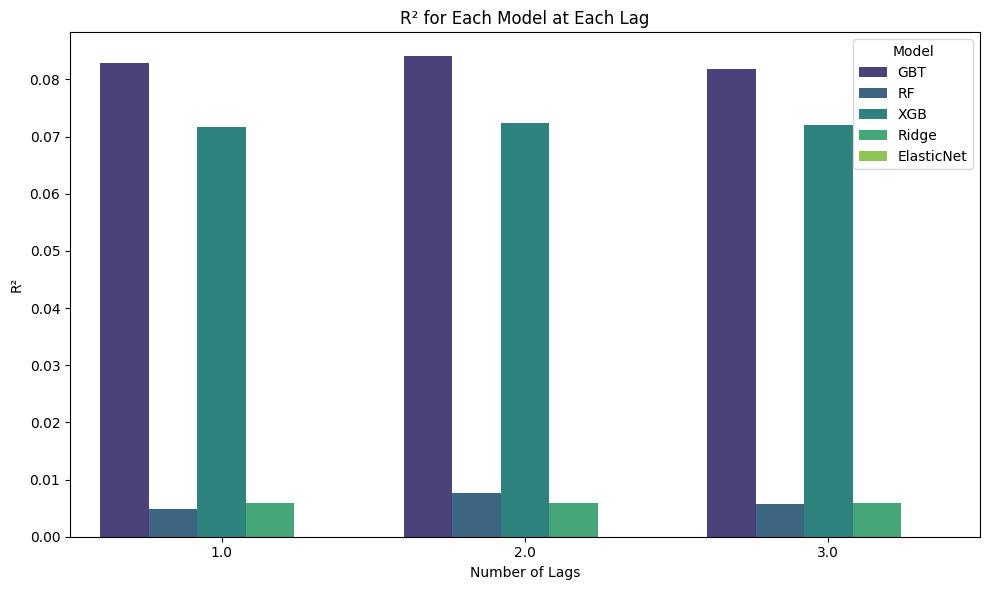

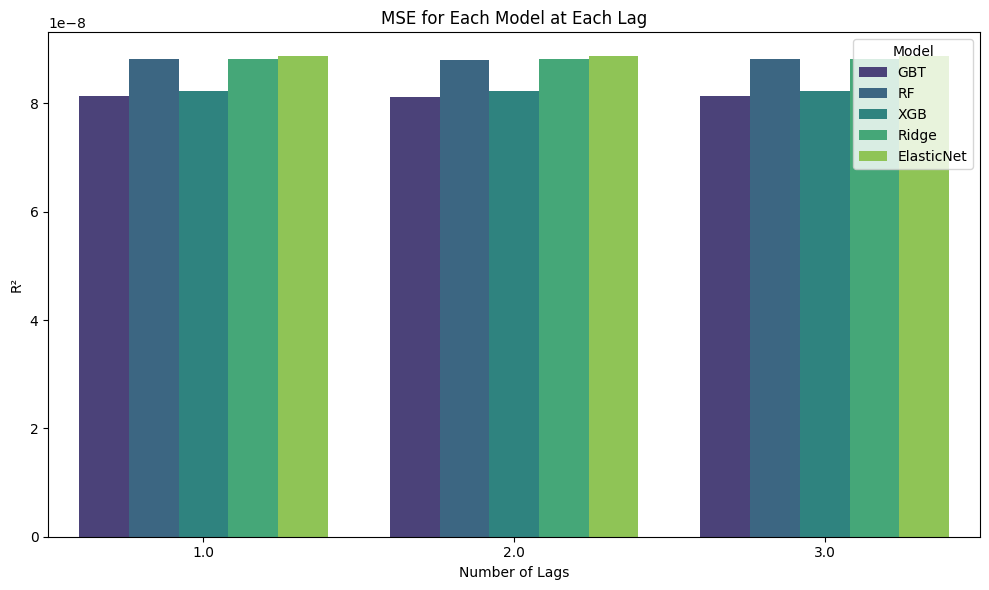

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("/data/workspace_files/lags.csv")
df = df.dropna(subset=["n_lags"])

# Convert n_lags to string or categorical so that Seaborn treats it as discrete
df['n_lags'] = df['n_lags'].astype(str)
df["R2"] = pd.to_numeric(df["R2"], errors="coerce").round(5)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df,
    x="n_lags",       # Lags on the X-axis
    y="R2",           # R² on the Y-axis
    hue="Model",      # Different bars (colors) for each model
    palette="viridis"
)

plt.title("R² for Each Model at Each Lag")
plt.xlabel("Number of Lags")
plt.ylabel("R²")
plt.legend(title="Model")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.barplot(
    data=df,
    x="n_lags",       # Lags on the X-axis
    y="MSE",           # R² on the Y-axis
    hue="Model",      # Different bars (colors) for each model
    palette="viridis"
)

plt.title("MSE for Each Model at Each Lag")
plt.xlabel("Number of Lags")
plt.ylabel("R²")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

### For different time frames

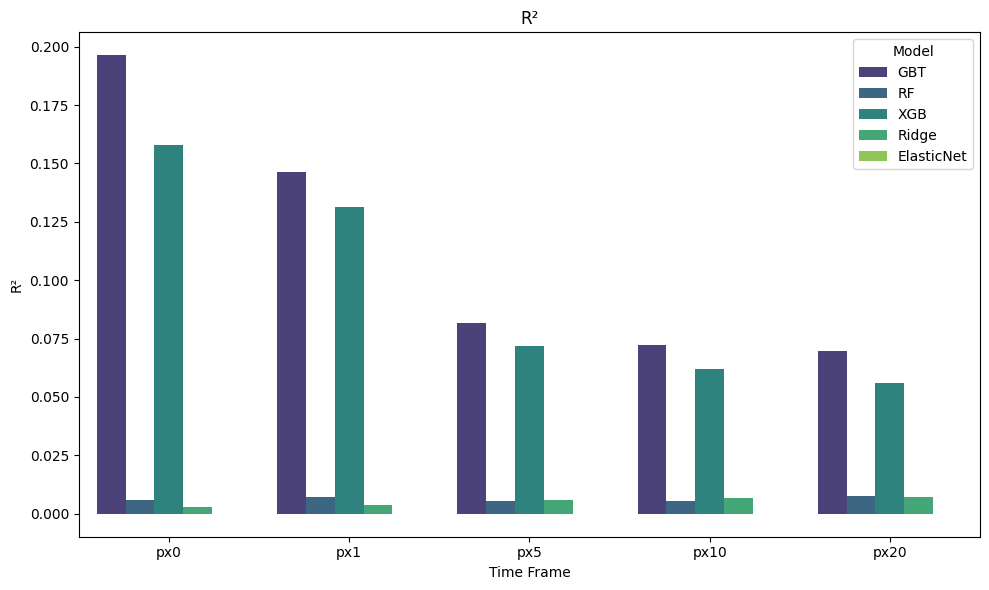

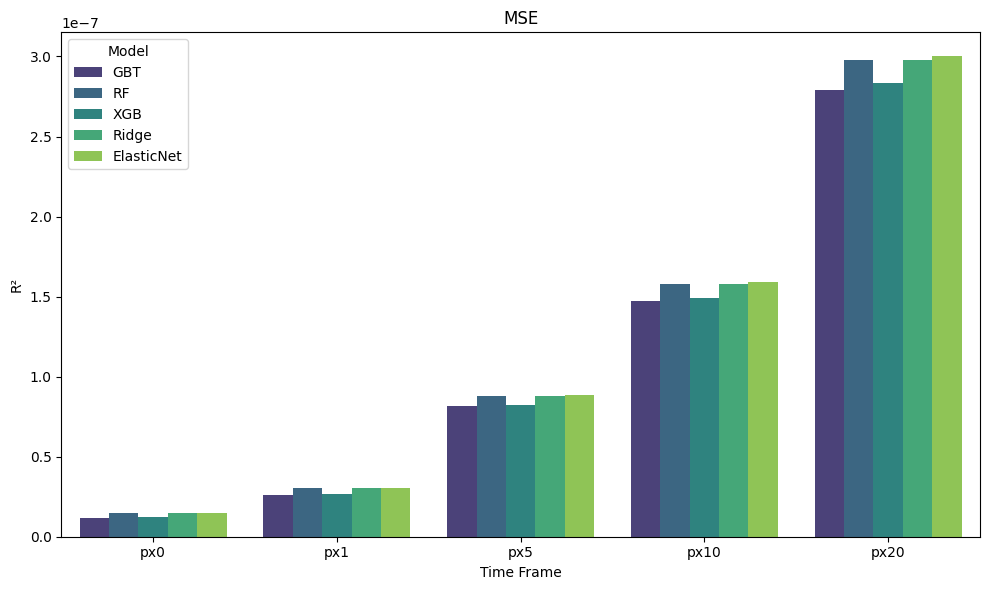

In [9]:
df = pd.read_csv("/data/workspace_files/timeframe.csv")
df = df.dropna(subset=["n_lags"])

df['n_lags'] = df['n_lags'].astype(str)
df["R2"] = pd.to_numeric(df["R2"], errors="coerce").round(5)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df,
    x="Timeframe",       # Lags on the X-axis
    y="R2",           # R² on the Y-axis
    hue="Model",      # Different bars (colors) for each model
    palette="viridis"
)

plt.title("R²")
plt.xlabel("Time Frame")
plt.ylabel("R²")
plt.legend(title="Model")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.barplot(
    data=df,
    x="Timeframe",       # Lags on the X-axis
    y="MSE",           # R² on the Y-axis
    hue="Model",      # Different bars (colors) for each model
    palette="viridis"
)

plt.title("MSE")
plt.xlabel("Time Frame")
plt.ylabel("R²")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

### For different latencies

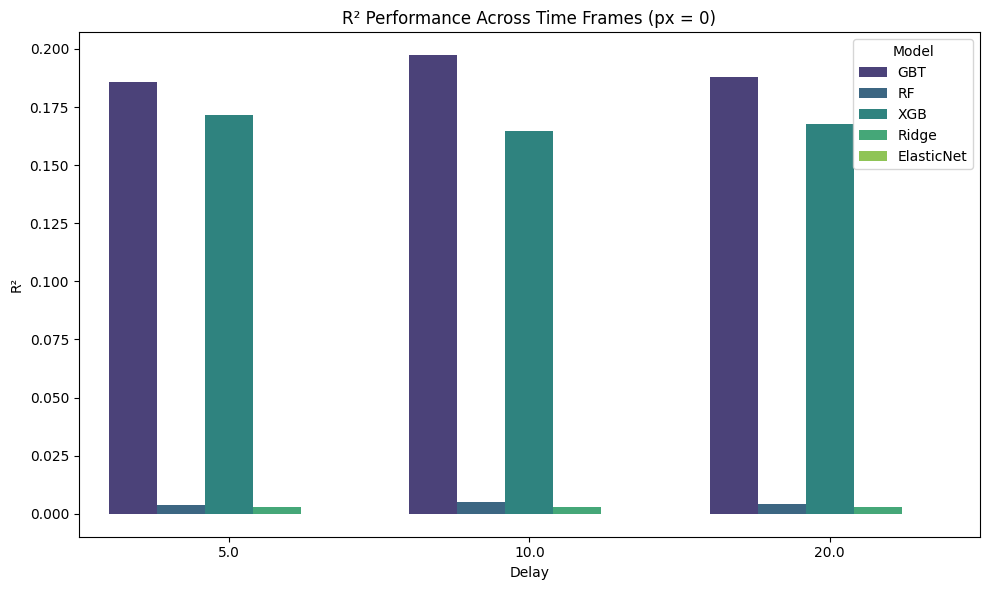

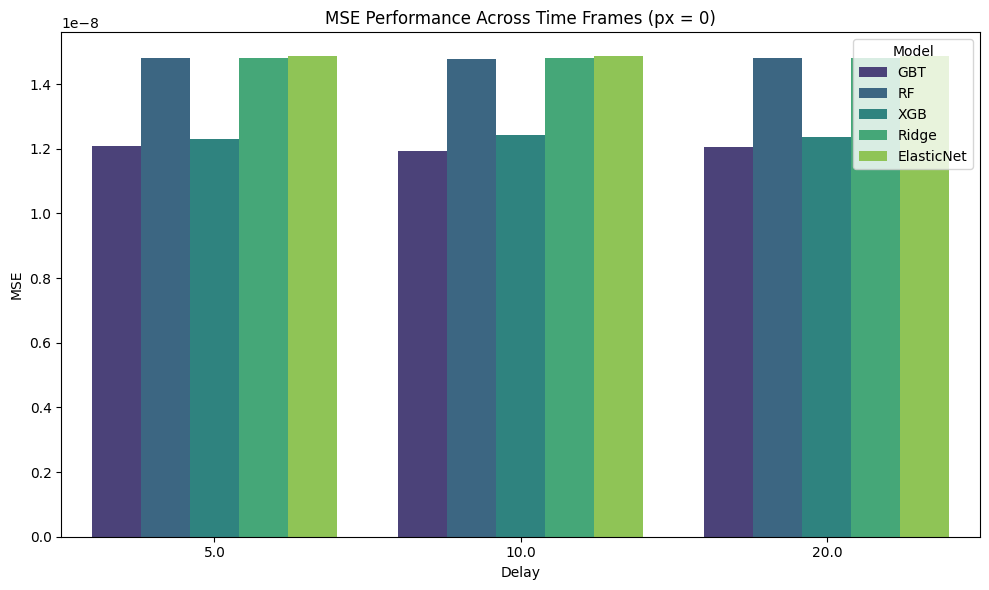

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read and prepare your data
df = pd.read_csv("/data/workspace_files/delays.csv")
df["MSE"] = pd.to_numeric(df["MSE"], errors="coerce")
df["R2"] = pd.to_numeric(df["R2"], errors="coerce")
df["Delay"] = pd.to_numeric(df["Delay"], errors="coerce")
df["Px"] = pd.to_numeric(df["Px"], errors="coerce")

# Filter for px = 0
df_px0 = df[df["Px"] == 0]

# Plot R² vs. Timeframe for px = 0
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_px0,
    x="Delay",       # X-axis: your time frame (e.g., lags)
    y="R2",              # Y-axis: R² values
    hue="Model",         # Different colors for each model
    palette="viridis"
)
plt.title("R² Performance Across Time Frames (px = 0)")
plt.xlabel("Delay")
plt.ylabel("R²")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Plot MSE vs. Timeframe for px = 0
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_px0,
    x="Delay",       # X-axis: your time frame (e.g., lags)
    y="MSE",             # Y-axis: MSE values
    hue="Model",         # Different colors for each model
    palette="viridis"
)
plt.title("MSE Performance Across Time Frames (px = 0)")
plt.xlabel("Delay")
plt.ylabel("MSE")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

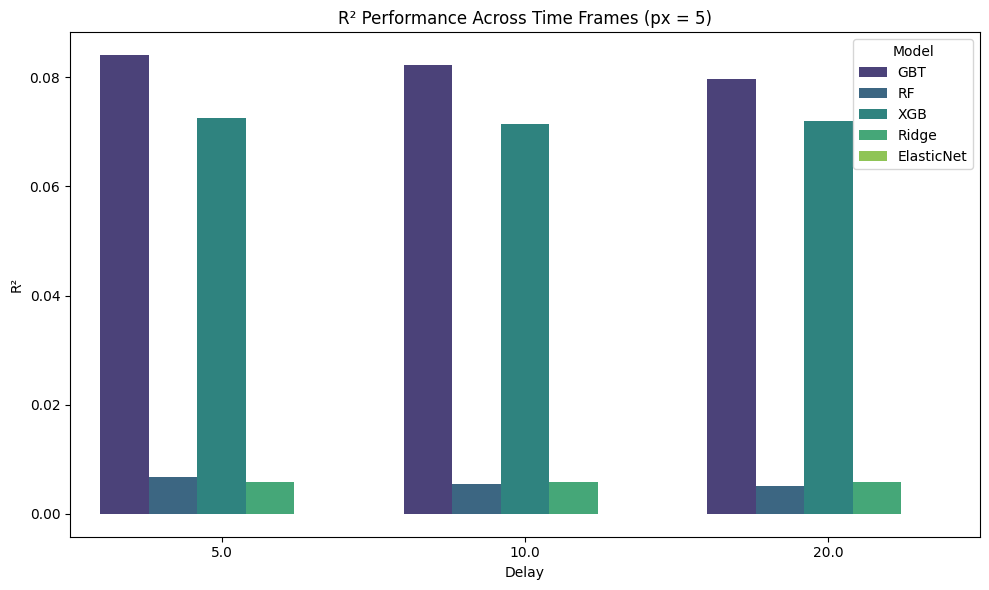

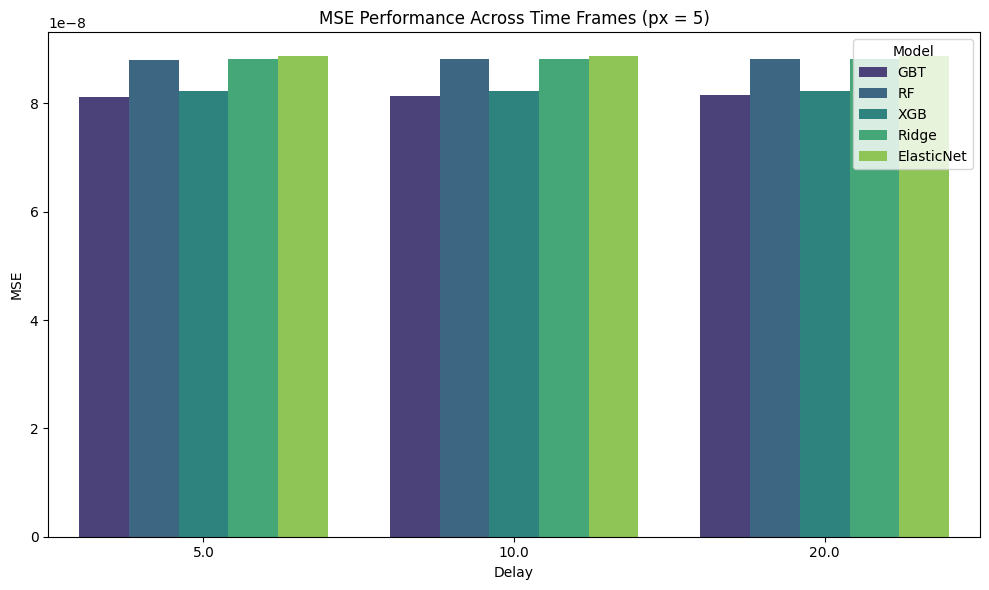

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read and prepare your data
df = pd.read_csv("/data/workspace_files/delays.csv")
df["MSE"] = pd.to_numeric(df["MSE"], errors="coerce")
df["R2"] = pd.to_numeric(df["R2"], errors="coerce")
df["Delay"] = pd.to_numeric(df["Delay"], errors="coerce")
df["Px"] = pd.to_numeric(df["Px"], errors="coerce")

# Filter for px = 0
df_px5 = df[df["Px"] == 5]

# Plot R² vs. Timeframe for px = 0
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_px5,
    x="Delay",       # X-axis: your time frame (e.g., lags)
    y="R2",              # Y-axis: R² values
    hue="Model",         # Different colors for each model
    palette="viridis"
)
plt.title("R² Performance Across Time Frames (px = 5)")
plt.xlabel("Delay")
plt.ylabel("R²")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Plot MSE vs. Timeframe for px = 0
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_px5,
    x="Delay",       # X-axis: your time frame (e.g., lags)
    y="MSE",             # Y-axis: MSE values
    hue="Model",         # Different colors for each model
    palette="viridis"
)
plt.title("MSE Performance Across Time Frames (px = 5)")
plt.xlabel("Delay")
plt.ylabel("MSE")
plt.legend(title="Model")
plt.tight_layout()
plt.show()